Dhananjay Tiwari,
Ph.D. Mechanical Engineering,
Mechanical Engineering Laboratory, 1204
University of Illinois at Urbana Champaign

This file has the code for implementation of FLPO optimization problem using using scipy optimizers

In [91]:
# include libraries and dependencies
import numpy as np # eh! computational python programming and not include this? Can't happen!
import matplotlib.pyplot as plt # module to make plots
from scipy import optimize # optimization module in scipy
from scipy.optimize import minimize # minimize function using various algorithms
from scipy.optimize import LinearConstraint # to define linear constraints

In [119]:
# create FLPO class and define its associated functions
class FLPO():

    # define data members of the class
    N : int # number of vehicles
    M : int # number of nodes
    K : int # number of stages
    uav_id : list # vehicle indices
    node_id : list # facility indices
    stop_id : list # destination id
    node_param : dict # node parameters

    stages : list # FLPO stages, K elements
                  #   Nx1  (M+1)x1  (M+1)x1   (M+1)x1    (M+1)x1       1x1
                  #   stg0   stg1    stg2     stg3 . . . . stgK-2     stgK-1
                  #    0      0        0        0  . . . .  0               
                  #    1      1        1        1  . . . .  1
                  #    2      2        2        2  . . . .  2          dest
                  #    .      .        .        .  . . . .  .
                  #    .      .        .        .  . . . .  .
                  #    .      M-1      M-1      M-1  . . .  M-1
                  #    .      dest    dest     dest  . . .  dest
                  #    N-1    
    
    asn_pb : list # list of list of arrays
                  #  --------------                                                                           --------------
                  # |          stagewise probability associations for a vehicle i = 0,1, . . , N-1                          |
                  # |    -----                                                                     -----                    |
                  # |   |                                                                               |                   |
                  # |   |   stg0 ----> stg1 ----------> stg2 -----> . . . . ----> stg(K-1) -----> stgK  |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |  . . . . .        |
                  # |   |  1x|stg1|  |stg1|x|stg2|    |stg2|x|stg3|   . . . .    |stg(K-1)|x|stgK|      |                   |
                  # |   |  matrix     matrix            matrix  . . . . . . .      matrix               |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |   |     .          .                .     . . . . . . .         .                 |                   |
                  # |    -----                                                                     -----                    |
                  #  -------------                                                                            --------------


    def __init__(self, N, M):
        # this function intializes the FLPO structure with assigned values
        
        # UAVs, nodes and stopping state indices
        self.N = N # initialize the number of vehicles
        self.M = M # initialize the number of nodes
        self.K = self.M + 2 # 1 initial stage + #intermediate stages equal to the number of facilities + 1 final stage
        self.uav_id = list(range(N)) # 0 1 2 . . . N-1
        self.node_id = list(range(N, N+M)) # N N+1 . . . N+M-1
        self.stop_id = list(range(N+M, N+M+1)) # N+M
        # initialize the initial and terminal nodes of all the UAVs as zeros
        self.uav_init = list(range(N)) # this value to be given by the user
        self.uav_stop = list(range(N)) # this value to be given by the user
        # initialize parameters associated to all the facilities
        self.node_param = dict()
        # self.fac_param['locations'] = np.zeros([M, 2])
        self.node_param['schedules'] = np.zeros([M, N]) # all M nodes have N components for each vehicle

        # define the structure of the stages and the elements in them
        self.stages = [0 for element in range(self.K)] # initialize list stages. Each 0 to be replaced with a column vector
        for stg in range(self.K):
            if stg == 0:
                # initial stage consisting of nodes
                self.stages[stg] = self.uav_id # Nx1 array
            elif stg == self.K-1:
                # final stage consists of only stopping state
                self.stages[stg] = self.stop_id # 1x1 array
            else:
                # other stages consist of facilities and destination
                self.stages[stg] = self.node_id + self.stop_id # (M+1) x 1 array
        
        # initialize association probabilities
        self.asn_pb = [[0 for element1 in range(self.K-1)] for element2 in range(N)]
        for n in range(N): # iteration over each node in the initial stage
            for stg in range(self.K-1): # iteration goes until the penultimate stage
                next_stage = self.stages[stg+1] # get the next stage nodes
                # initialize probabilities as ones (normalized in the next step)
                if stg == 0:
                    # self.asn_pb[n][stg] = np.ones([1, len(next_stage)]) # uniform distribution
                    self.asn_pb[n][stg] = np.random.rand(1, len(next_stage)) # normal distribution
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None] # normalize
                else:
                    # self.asn_pb[n][stg] = np.ones([len(self.stages[stg]), len(self.stages[stg+1])]) # uniform distribution
                    self.asn_pb[n][stg] = np.random.rand(len(self.stages[stg]), len(self.stages[stg+1])) # normal distribution
                    self.asn_pb[n][stg] = self.asn_pb[n][stg]/self.asn_pb[n][stg].sum(axis = 1)[:, None] # normalize

    # assign an initial node to a UAV
    def set_init_node(self, uav, init_node):
        id_uav = self.uav_id.index(uav) # get the UAV index
        self.uav_init[id_uav] = init_node # assign the initial node to the corresponding index
    
    # access the initial node of a UAV
    def get_init_node(self, uav):
        id_uav = self.uav_id.index(uav) # get the UAV index
        return self.uav_init[id_uav] # return the corresponding UAV initial node
    
    # assign a terminal node to a UAV
    def set_stop_node(self, uav, stop_node):
        id_uav = self.uav_id.index(uav) # get the UAV index
        self.uav_stop[id_uav] = stop_node # assign the terminal node to the corresponding index

    # access the terminal node of a UAV
    def get_stop_node(self, uav):
        id_uav = self.uav_id.index(uav) # get the UAV index
        return self.uav_stop[id_uav] # return the corresponding UAV terminal node

    # define stage transportation cost for each node        
    def cost_stage_transit(self, n, stg, i, j):
        # this function gives the value of stage transition cost for node n
        # from node i in stage stg to node j in stage stg+1
        # for now the cost is defined based on the facility schedules
        # print(' -- Data type of node parameters -- ' , type(self.node_param))
        t = self.node_param['schedules'] # a 2D matrix with each row representing a facility, and every column representing a node
        # get the indices of i and j and vehicle n
        id_i = self.stages[stg].index(i)
        id_j = self.stages[stg+1].index(j)
        id_n = self.uav_id.index(n)

        # define the constant for lower and upper time bound penalties respectively
        nu = 1
        eta = 1
        
        if i in self.node_id and j in self.node_id:
            # time taken to move from node i to node j by vehicle n in intermediate nodes
            # the cost penalizes vehicles if they take a minimum of 30 second and a maximum of 80 second
            # to traverse between the nodes
            cost = t[id_j, id_n] - t[id_i, id_n] + \
                 np.exp(nu * (10 - (t[id_j, id_n] - t[id_i, id_n]))) + \
                    np.exp(eta * ((t[id_j, id_n] - t[id_i, id_n]) - 30))
        elif i in self.node_id and j in self.stop_id:
            # if transition is from a node to stopping state
            if i == self.get_stop_node(n):
                # if the current node is the destination of vehicle n then zero cost
                cost = 0
            else:
                # else high penalty
                cost = 100
        elif i in self.stop_id and j in self.node_id:
            # if transition is from a stopping state to a node
            cost = 100 # the penalty is high
        elif i in self.stop_id and j in self.stop_id:
            # zero cost for stage-transition from stop to stop
            cost = 0


        # if i == j and j != self.stop_id[0]:
        #     # self-hopping has very high penalty unless its stop --> stop transition
        #     cost = 100
        # elif i == j and j == self.stop_id[0]:
        #     # self-hopping has very high penalty unless its stop --> stop transition
        #     cost = t[id_j, id_n] - t[id_i, id_n]
        # # elif i == self.stop_id and j != self.stop_id:
        # #     # vehicle cannot go to a node other than stopping state from the stopping state
        # #     cost = 100
        # else:
        #     # time taken to move from node i to node j by vehicle n in intermediate nodes
        #     # the cost penalizes vehicles if they take a minimum of 30 second and a maximum of 80 second
        #     # to traverse between the nodes
        #     cost = t[id_j, id_n] - t[id_i, id_n] + \
        #          np.exp(nu * (30 - (t[id_j, id_n] - t[id_i, id_n]))) + \
        #             np.exp(eta * ((t[id_j, id_n] - t[id_i, id_n]) - 80))

        return cost
    

    # define the distortion function of a node 
    def distortion(self, n): 
        # this function computes the distortion function of a node n using probability associations and parameters of facilities for the corresponding vehicle
        if n not in self.uav_id: # check if the vehicle argument is valid or not
            print('invalid node id')
        else:
            # initialize the distortion data structure (same as stages data structure)
            D = [np.zeros(1)]
            D = D + [np.zeros(len(self.stages[stg])) for stg in range(1,self.K)]
            # print('\n-- Distortion Matrix --\n')
            # print(D)
            # for row in D:
            #     print(row)

            # iterate over stages : final stage --> initial stage
            stg_ids = list(range(self.K))
            stg_ids_rev = stg_ids[::-1]
            for stg in stg_ids_rev:
                # print('stage -- ' , stg)
                # iterate over each element of the chosen stage
                if stg > 0:
                    for i in self.stages[stg]:
                        id_i = self.stages[stg].index(i)
                        # print('  i -- ' , i, id_i)
                        D[stg][id_i] = 0
                        if stg == self.K-1:
                            D[stg][id_i] = 0
                        else:
                            for j in self.stages[stg+1]:
                                id_j = self.stages[stg+1].index(j)
                                print('    j -- ' , j , id_j, D[stg][id_i])
                                D[stg][id_i] = D[stg][id_i] + self.asn_pb[n][stg][id_i, id_j] * (D[stg+1][id_j] + self.cost_stage_transit(n, stg, i, j))
                elif stg == 0:
                    i = n
                    id_i = 0
                    # print('  i -- ' , i , id_i)
                    for j in self.stages[stg+1]:
                        id_j = self.stages[stg+1].index(j)
                        # print( '    j -- ' , j, id_j, self.cost_stage_transit(n, stg, i, j))
                        D[stg][id_i] = D[stg][id_i] + self.asn_pb[n][stg][id_i, id_j] * (D[stg+1][id_j] + self.cost_stage_transit(n, stg, i, j))
        return D[0][0]
    

    def entropy(self, n): # depends on probability associations
        # ToDo
        return 0


    def free_energy():
        # ToDo
        return 0


    def flat_asn_pb(self, asn_pb):
        # this function unwraps the association probabilities into a column vector

        vec = []
        # unwrap for a vehicle, and then put them all together
        for uav_pb in asn_pb:
            for stg_pb in uav_pb:
                vec = vec + list(stg_pb.flatten())

        return vec


    def wrap_flat_asn_pb(self, vec_asn_pb):
        # this function wraps the association probabilities into their original defined structure inside __init__() function
        # vec_asn_pb (list) should contain probability association corresponding to all the vehicles otherwise the function prints error

        # initialize the required structure of association probability we need
        asn_pb = [[0 for element1 in range(self.K-1)] for element2 in range(self.N)]

        # get the dimension of probability association for a single vehicle
        dim_uav = 0
        # iterate over the stages to compute the above required dimension
        for stg in range(self.K-1):
            if stg == 0:
                dim_uav = dim_uav + len(self.stages[stg+1])
            else:
                dim_uav = dim_uav + len(self.stages[stg])*len(self.stages[stg+1])
        
        # dim_uav times the number of vehicles should be dim of vec_asn_pb
        if dim_uav * len(self.uav_id) != int(len(vec_asn_pb)):
            print('invalid dimension of association probability vector')
        else:
            for uav in self.uav_id:
                # get the index of uav
                n = self.uav_id.index(uav)
                # slice the probability vector for the corresponding vehicle
                sliced_vec = vec_asn_pb[n*dim_uav : (n+1)*dim_uav]
                k = 0
                for stg in range(self.K-1):
                    if stg == 0:
                        asn_pb[n][stg] = np.reshape( sliced_vec[k : k + 1*len(self.stages[stg+1])] , [1, len(self.stages[stg+1])] )
                        k = k + 1*len(self.stages[stg+1])
                    else:
                        asn_pb[n][stg] = np.reshape( sliced_vec[k : k + len(self.stages[stg])*len(self.stages[stg+1])] , [len(self.stages[stg]), len(self.stages[stg+1])] )
                        k = k + len(self.stages[stg])*len(self.stages[stg+1])
        
        return asn_pb


    def flat_schedules(self, schedules):
        # this converts the original data structure of schedules (see __init__() function) into a 1D array
        return list(schedules.flatten())


    def wrap_flat_schedules(self, vec_schedules):
        # this converts the 1D array of schedules into its original defined structure (see __init__() function)
        
        # first check if the dimension is correct
        dim = len(vec_schedules)
        print('length of vectorized schedules = ' , len(vec_schedules))
        print('number of nodes = ' , len(self.node_id))
        print('number of UAVs = ' , len(self.uav_id))
        if dim != len(self.node_id) * len(self.uav_id):
            print('invalid dimension of the parameters for time-schedule')

        return np.reshape(vec_schedules, [len(self.node_id)+len(self.stop_id), len(self.uav_id)])


    def cons_asn_pb(self, vec_asn_pb):
        # this function constraints the distributions that the sum of probabilities at every node is 1 for every vehicle
        # input : consists of all the probability associations in the vector form
        # output : consists of linear constraints as required by scipy.optimize.minimize function

        # get the dimension of probability association for a single vehicle
        dim_uav = 0
        # iterate over the stages to compute the above required dimension
        for stg in range(self.K-1):
            if stg == 0: # in the zeroth stage only 1 vehicle is considered and multiplied with the dimension of stage 1
                dim_uav = dim_uav + 1 * len(self.stages[stg+1])
            else: # otherwise the original dimensions of the current stage is multiplied with that the next one
                dim_uav = dim_uav + len(self.stages[stg]) * len(self.stages[stg+1])
        
        # print('dim_uav = ' , dim_uav)
        # print('number of UAVs = ' , len(self.uav_id))
        # print('length of vectorized associations = ' , len(vec_asn_pb))
        # dim_uav times the number of vehicles should be dim of vec_asn_pb
        if dim_uav * len(self.uav_id) != len(vec_asn_pb):
            print('invalid dimension of association probability vector')

        # the number of equality constraints is equal to the sum of cardinality of every stage (except the first and the final stage)
        num_eq_cons = 0
        # iterate over the vehicles
        for n in range(self.N):
            # iterate till the penultimate stage
            for stg in range(self.K-1):
                if stg == 0: # in the initial stage, only vehicle n is counted
                    num_eq_cons = num_eq_cons + 1
                else: # otherwise count all the nodes in a stage
                    num_eq_cons = num_eq_cons + len(self.stages[stg])

        # initialize the linear constraint matrix
        fat_mat = [[0 for i in range(len(vec_asn_pb))] for j in range(num_eq_cons)]
        # initialize counters
        row_count = 0 # to trace rows of fat_mat
        col_count = 0 # to trace cols of fat_mat
        # iterate over vehicles
        for n in range(self.N):
            # corresponding to the first transition of a vehicle
            # iterate over stages from 1 to K-1
            for stg in range(self.K-1):
                if stg == 0:
                    # iteration over stage 1 for columns of fat_mat in the first row
                    for j in range(len(self.stages[stg+1])):
                        fat_mat[row_count][col_count] = 1
                        col_count = col_count + 1 # update column count for the next column
                    row_count = row_count + 1 # update row count for the next row
                else:
                    # iterate over the rows that correspond to the current stage
                    for i in range(len(self.stages[stg])):
                        # iterate over the that cols correspond to the next stage
                        for j in range(len(self.stages[stg+1])):
                            fat_mat[row_count][col_count] = 1
                            col_count = col_count + 1 # update column count for the next column
                        row_count = row_count + 1 # update row count for the next row
            
        # define the lower bound for linear inequality/equality constraints
        lb = list(np.ones(num_eq_cons)) # all probability distributions sum to 1
        # define the upper bound for linear inquality/equality constraints (equal to lb in case of equality)
        ub = list(np.ones(num_eq_cons)) # all probability distributions sum to 1

        # define the linear constraint in the form needed for scicpy.optimize.minimize
        lin_con = LinearConstraint(fat_mat, lb, ub) 

        return lin_con
    

    def objective(self, x):
        # this function computes the objective of the FLPO problem from distortion of each vehicle and entropy
        # of probability associations for each vehicle
        # input : x = [ flat_asn_pb , time_schedules ] is a vector consisting of all the probability associations and node time schedule parameters

        # get the number of probability association variables
        dim_pb = 0
        # iterate over the stages to compute the above required dimension
        for n in range(self.N):
            for stg in range(self.K-1):
                if stg == 0: # in the zeroth stage only 1 vehicle is considered and multiplied with the dimension of the stage 1
                    dim_pb = dim_pb + 1 * len(self.stages[stg+1])
                else: # otherwise the original dimensions of the current stage is multiplied with that the next one
                    dim_pb = dim_pb + len(self.stages[stg]) * len(self.stages[stg+1])
        # print('<< Inside objective() function >> \n << print the number of association probabilities >> ' , dim_pb)
        asn_pb = self.wrap_flat_asn_pb(x[0:dim_pb]) # probability association component of x
        params = self.wrap_flat_schedules(x[dim_pb:]) # time-schedules component of x

        # assign the association probabilities and node parameters 
        self.asn_pb = asn_pb
        self.node_param = params

        # initialize the total cost
        cost = 0

        # initialize the weights given to each vehicle
        uav_weights = np.ones(len(self.uav_id))/len(self.uav_id) # uniform distribution for now

        # compute distortion cost by performing weighted sum over each vehicle
        distortion_cost = 0
        for n in self.uav_id:
            id_n = self.uav_id.index(n) # get index
            distortion_cost = distortion_cost + uav_weights[id_n] * self.distortion(n) # update the weighed sum

        # ToDo : compute entropy cost by performing weighted sum over each vehicle
        
        # total cost
        cost = distortion_cost # + entropy_cost

        return cost



Minimize the distortion of FLPO with respect to probability associations and node schedule parameters

In [120]:
# initialize variables
N = 2 # number of vehicles
M = 4 # number of nodes

# define functions
def printMatrix(mat , mat_name):
    print(mat_name)
    for row in mat:
        print(row , '\n')
    return 0

# create an instance of FLPO class
flpo = FLPO(N, M) 

# set the initial and stop points, and initial time for all the UAVs
init_nodes = [2, 3]
stop_nodes = [5, 4]
init_time = [1.0, 1.0]
for i in range(N):
    flpo.set_init_node(flpo.uav_id[i], init_nodes[i])
    flpo.set_stop_node(flpo.uav_id[i], stop_nodes[i])
    flpo.node_param['schedules'][init_nodes[i], i] = init_time[i]

# print variales
# print(' -- Stages --\n' , flpo.stages)
# print(' \n-- Association probabilities --\n' , flpo.asn_pb)
# vec_asn_pb = flpo.flat_asn_pb(flpo.asn_pb)
# print(' \n-- Flattened Association Probabilities --\n ' , vec_asn_pb)
# print(' \n-- Wrapped Association Probailities --\n ' , flpo.wrap_flat_asn_pb(vec_asn_pb))

# print(' \n-- Time schedules --\n ' , flpo.node_param['schedules'])
# flat_time_schedules = flpo.flat_schedules(flpo.node_param['schedules'])
# print(' \n-- Flattened time schedules --\n' , flat_time_schedules)
# print(' \n-- Wrapped time schedules --\n' , flpo.wrap_flat_schedules(flat_time_schedules))

# fat_mat = flpo.cons_asn_pb(vec_asn_pb)
# printMatrix(fat_mat , 'Probability associations constraint matrix')

vec_asn_pb = flpo.flat_asn_pb(flpo.asn_pb)
vec_schedules = flpo.flat_schedules(flpo.node_param['schedules'])

x0 = vec_asn_pb + vec_schedules
# print(x0)
# print(np.array(vec_asn_pb).shape)
probability_cons = flpo.cons_asn_pb(vec_asn_pb)
res = minimize(flpo.objective, x0) #, constraints = probability_cons)

length of vectorized schedules =  8
number of nodes =  4
number of UAVs =  2


ValueError: cannot reshape array of size 8 into shape (5,2)

[1.01       1.03512821 1.06025641 1.08538462 1.11051282 1.13564103
 1.16076923 1.18589744 1.21102564 1.23615385 1.26128205 1.28641026
 1.31153846 1.33666667 1.36179487 1.38692308 1.41205128 1.43717949
 1.46230769 1.4874359  1.5125641  1.53769231 1.56282051 1.58794872
 1.61307692 1.63820513 1.66333333 1.68846154 1.71358974 1.73871795
 1.76384615 1.78897436 1.81410256 1.83923077 1.86435897 1.88948718
 1.91461538 1.93974359 1.96487179 1.99      ]


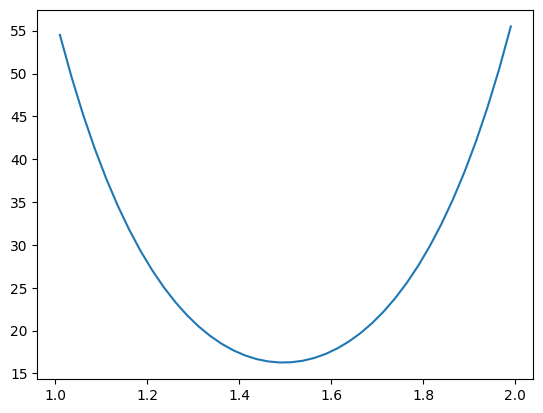

In [122]:
#just a test block

x = np.linspace(1.01, 1.99, 40)
print(x)
a = 4
b = 4
fx = x + np.exp(-a*(1 - x)) + np.exp(-b*(x - 2))
# fx = x + 1/(x-1) + 1/(2 - x)

plt.plot(x, fx)
plt.show()